# 1. Import the required libraries

In [3]:
# # Standard code libraries
import os
import platform
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Custom code libraries from ReSurfEMG
#repo_path = 'C:\SEISMIC_study\ReSurfEMG'
#sys.path.append(repo_path)

from resurfemg.config.config import Config
from resurfemg.data_classes.data_classes import (
VentilatorDataGroup, EmgDataGroup, TimeSeries)
from resurfemg.preprocessing.ecg_removal import *


%matplotlib widget

## 2. Load the ventilator and sEMG data

In [4]:
# Identify all recordings available for the selected patient/measurement_date

# Root directory for test data
config = Config()
root_patient_data_directory = \
    config.get_directory('root_emg_directory')

if platform.system() == 'Windows':
    path_sep = "\\"
else:
    path_sep = '/'

emg_pattern = os.path.join(root_patient_data_directory, '**/*.npy')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'paw' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

emg_file_chosen = emg_files[5]
vent_file_chosen = vent_files[5]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 E:\Data_CSV_renamed_voor_resurf\two_track_emg_Rotterdam_SEISMIC-002_t0.npy 
 E:\Data_CSV_renamed_voor_resurf\paw_Rotterdam_SEISMIC-002_t0.npy


In [5]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg_samples = np.load(emg_file_chosen)
fs_emg = 2048
data_vent_samples = np.load(vent_file_chosen)
fs_vent = 100

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

In [6]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['Costmar', 'Intercost'],
    units=2*['uV'])


# Data is stored in:
# fs        --> emg_timeseries.fs
# labels    --> emg_timeseries.labels
# units     --> emg_timeseries.units
# ECG       --> emg_timeseries.channels[0] = TimeSeries object
# EMGdi     --> emg_timeseries.channels[1: TimeSeries object
# peaks     --> emg_timeseries.peaks
#   with:
#   emg_timeseries.channels[0].fs = fs
#   emg_timeseries.channels[0].y_raw = y_emg[0, :]
#   emg_timeseries.channels[0].t_data = time axis data for y_raw
#   emg_timeseries.channels[0].y_clean = None
#   emg_timeseries.channels[0].y_baseline = None
#   emg_timeseries.channels[0].y_baseline = None
#   etc.
# From the labels 'ECG' is automatically detected.


In [7]:
# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw'],
    units=['cmH2O'])

# Data is stored in:
# fs        --> vent_timeseries.fs
# labels    --> vent_timeseries.labels
# units     --> vent_timeseries.units
# ECG       --> vent_timeseries.channels[0: TimeSeries object
# EMGdi     --> vent_timeseries.channels[1] = TimeSeries object
#   with:
#   vent_timeseries.channels[0].fs = fs
#   vent_timeseries.channels[0].y_raw = y_vent[0, :]
#   vent_timeseries.channels[0].t_data = time axis data for y_raw
#   vent_timeseries.channels[0].y_clean = None
#   vent_timeseries.channels[0].y_baseline = None
#   vent_timeseries.channels[0].y_baseline = None
#   etc.
# From the labels 'P_aw', 'F', and 'Vvent' are automatically detected.

Auto-detected Paw channel from labels.


# 3. Pre-process the data

(-100.0, 100.0)

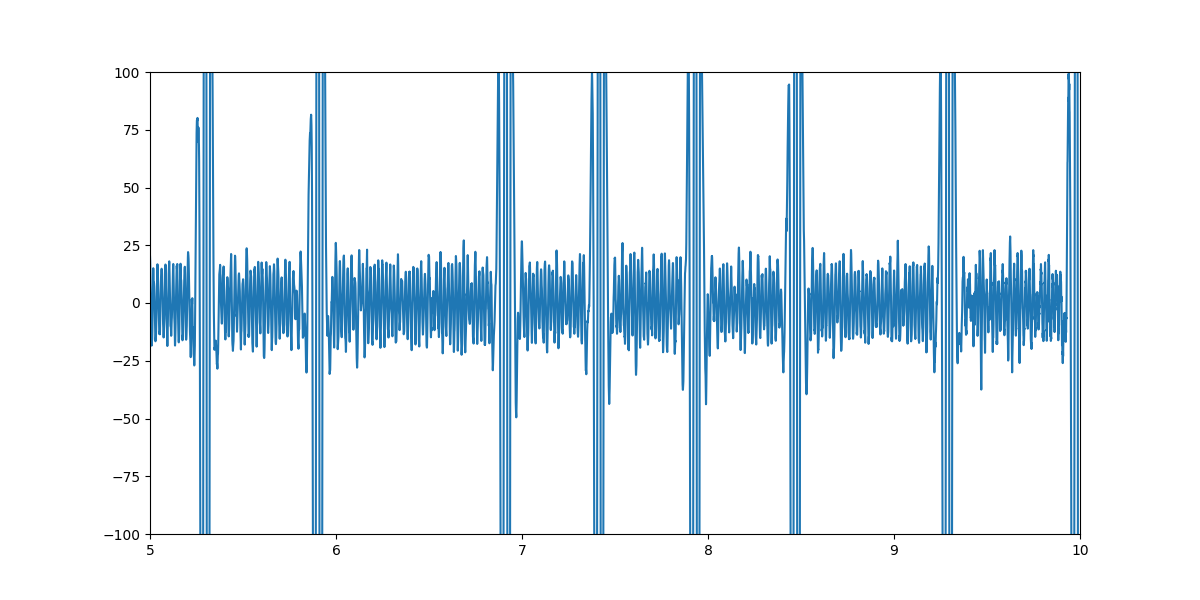

In [8]:
# Filter
emg_timeseries.filter()
# Which equals:
# emg_timeseries.filter(
#     signal_type='raw',
#     hp_cf=20.0,
#     lp_cf=500.0,    
#     channel_idxs=[0, 1],
# )
# Where:
# signal_type:      Filter the raw, just assigned, data
# hp_cf:            High-pass cut-off frequency of 20 Hz
# lp_cf:            Low-pass cut-off frequency of 500 Hz
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean

clean_after_hp0 = emg_timeseries.channels[0].y_clean
clean_after_hp1 = emg_timeseries.channels[1].y_clean

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(t_emg,emg_timeseries.channels[0].y_clean, label='Signal after removing outliers')
plt.xlim([5, 10])
plt.ylim([-100, 100])

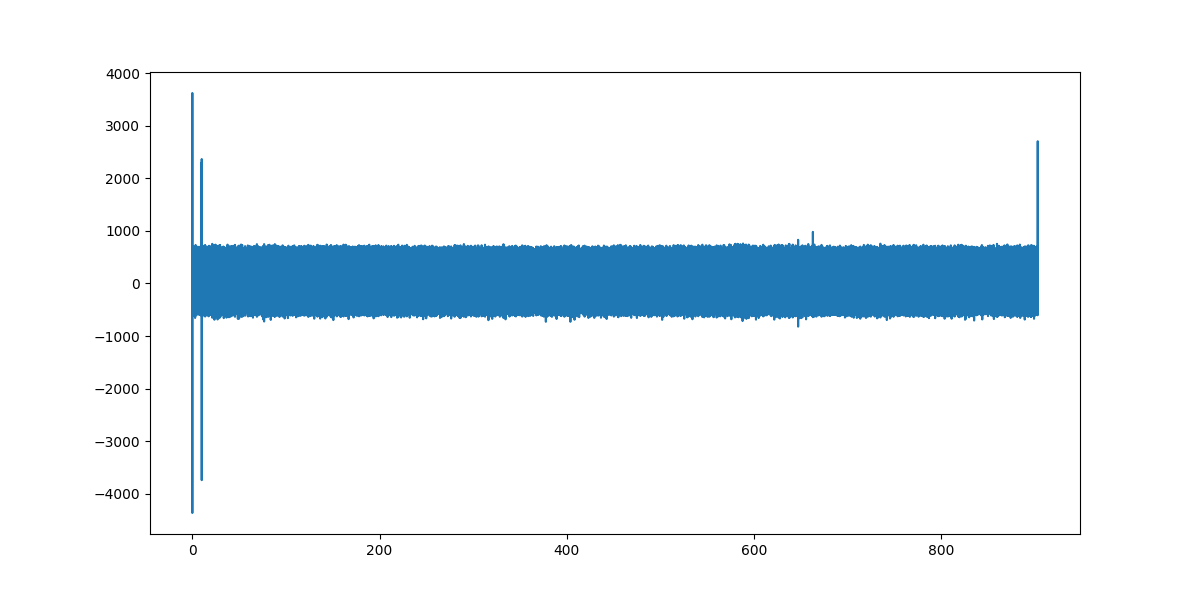

In [9]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(t_emg,emg_timeseries.channels[0].y_clean, label='Signal after removing outliers')

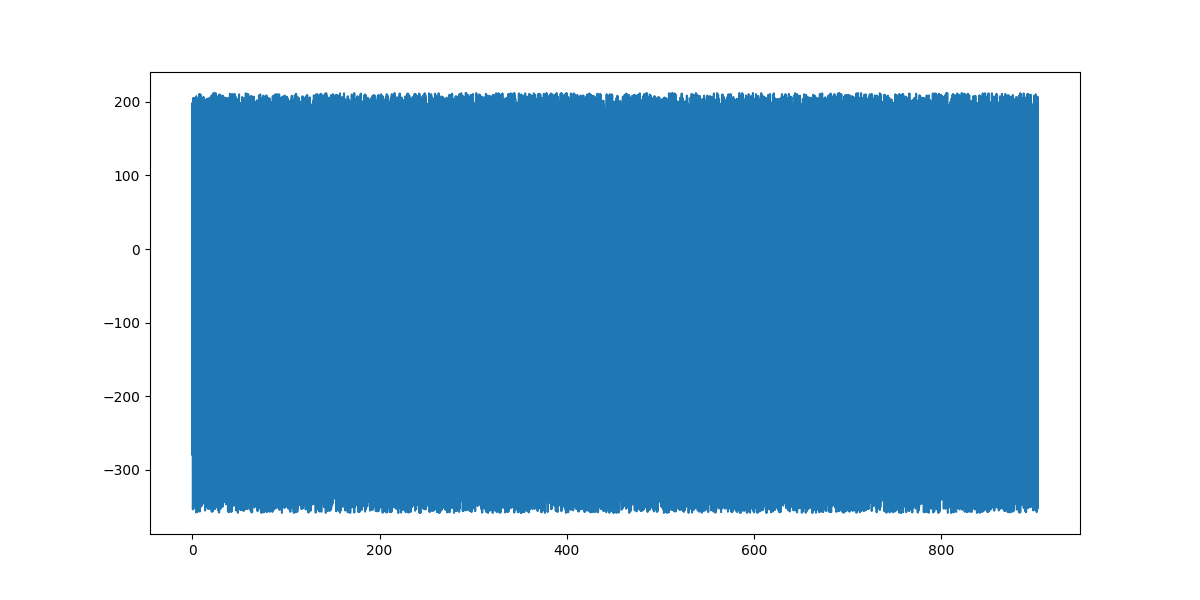

In [10]:
emg_timeseries.remove_outliers()
# Which equals:
# emg_timeseries.remove_outliers(
#     signal_type='clean',  
#     channel_idxs=[0, 1],
#     lowest_threshold=None
# )
# Where:
# signal_type:      Filter the clean, just filtered, data
# channel_idxs:     For all channels (None would default to this)
# lowest_threshold: Default is 20 uV

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(t_emg,emg_timeseries.channels[0].y_clean, label='Signal after removing outliers')
#plt.plot(t_emg,src_signal_gated, label='Signal after gating')
#plt.xlim([5, 10])
#plt.ylim([-300, 150])
#plt.axhline(mean_signal, linestyle='--')

(5.0, 10.0)

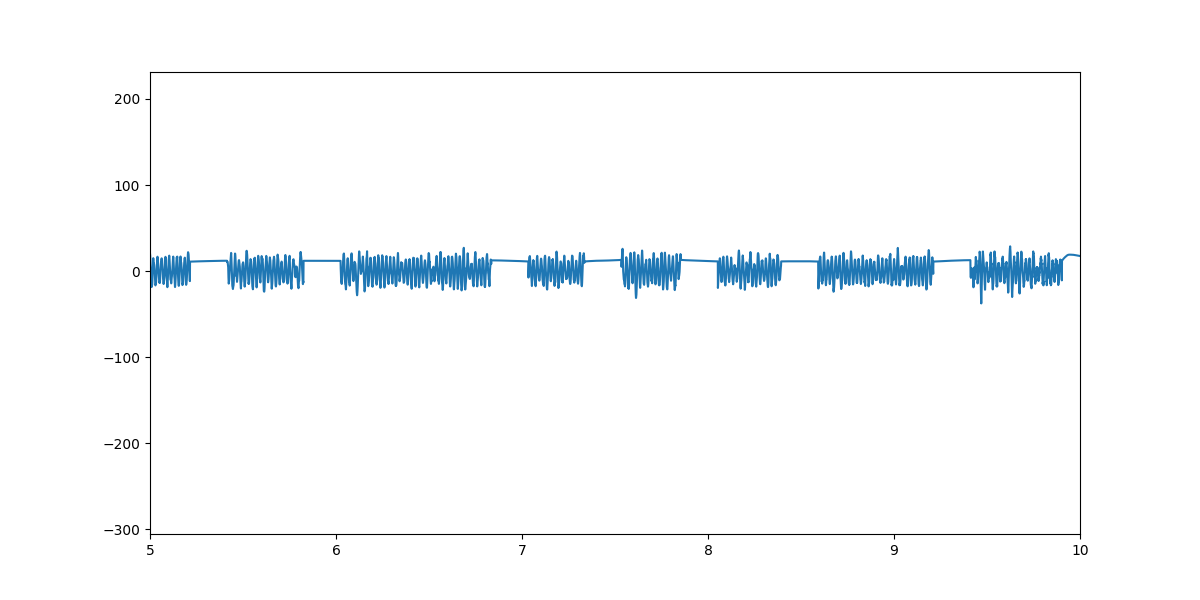

In [11]:
# Gate the EMG
emg_timeseries.gating(gate_width_samples = fs_emg // 5, use_no_outliers=True)
# Which equals:
# emg_timeseries.gating(
#     signal_type='clean',        
#     gate_width_samples=None,    
#     ecg_peak_idxs=None,         
#     ecg_raw=None,               
#     bp_filter=True,
#     channel_idxs=None,
#     use_no_outliers = None
# )
# Where:
# signal_type:          Filter the clean, just filtered, data
# gate_width_samples:   Gate width, `None` defaults to fs // 10
# ecg_peak_idxs:        Sample idxs of ECG peaks, when `None` peaks are 
#                       automatically identified.
# ecg_raw:              ECG data to detect ECG peaks in if no ecg_peak_idxs are
#                       provided. If `None` and no ecg-channel is detected
#                       from the labels the raw channel data is used.
# bp_filter:            True/False: Filter the provided ecg_raw between 1-500
#                       Hz before peak detection
# channel_idxs:         For all channels (None would default to this)
# use_no_outliers:      True if outliers are present in the raw data. None is default.

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(t_emg,emg_timeseries.channels[0].y_clean)
plt.xlim([5, 10])
#plt.ylim([-50, 50])


(5.0, 10.0)

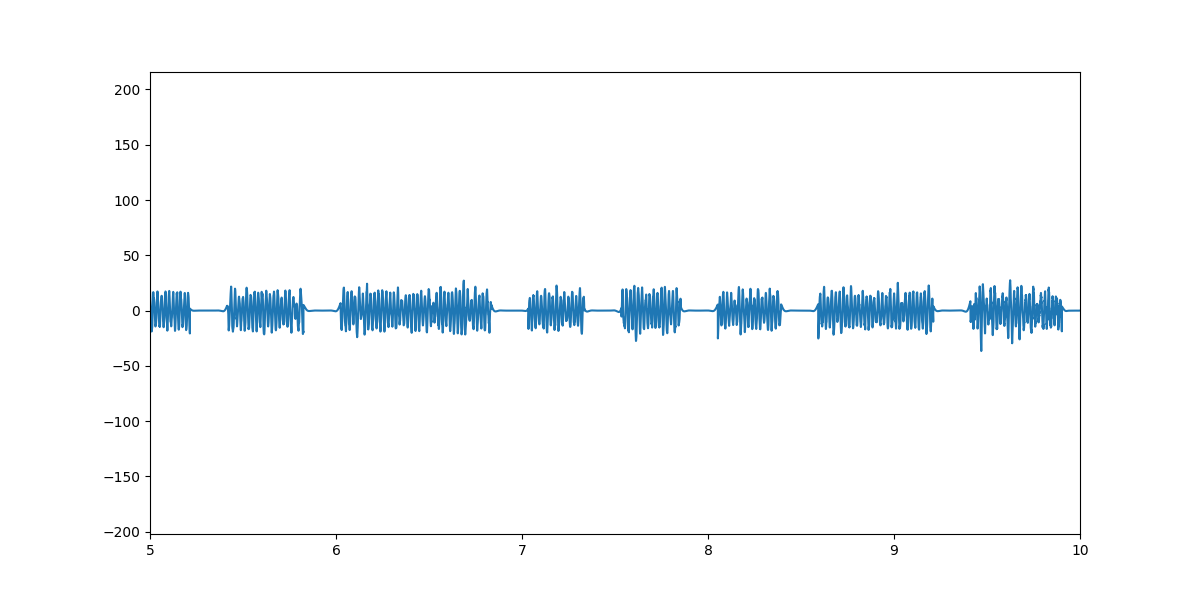

In [12]:
# Filter to remove P- and S-peak
emg_timeseries.filter_QS()
# Which equals:
# emg_timeseries.filter_QS(
#      signal_type='clean',
#      high_pass = None,
#      channel_idxs=None,
# )
# Where:
# signal_type:          Filter the clean, just filtered, data
# high_pass:            Cut off frequency, default is 20 Hz.
# channel_idxs:         For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(t_emg,emg_timeseries.channels[0].y_clean)
plt.xlim([5, 10])
#plt.ylim([-50, 50])

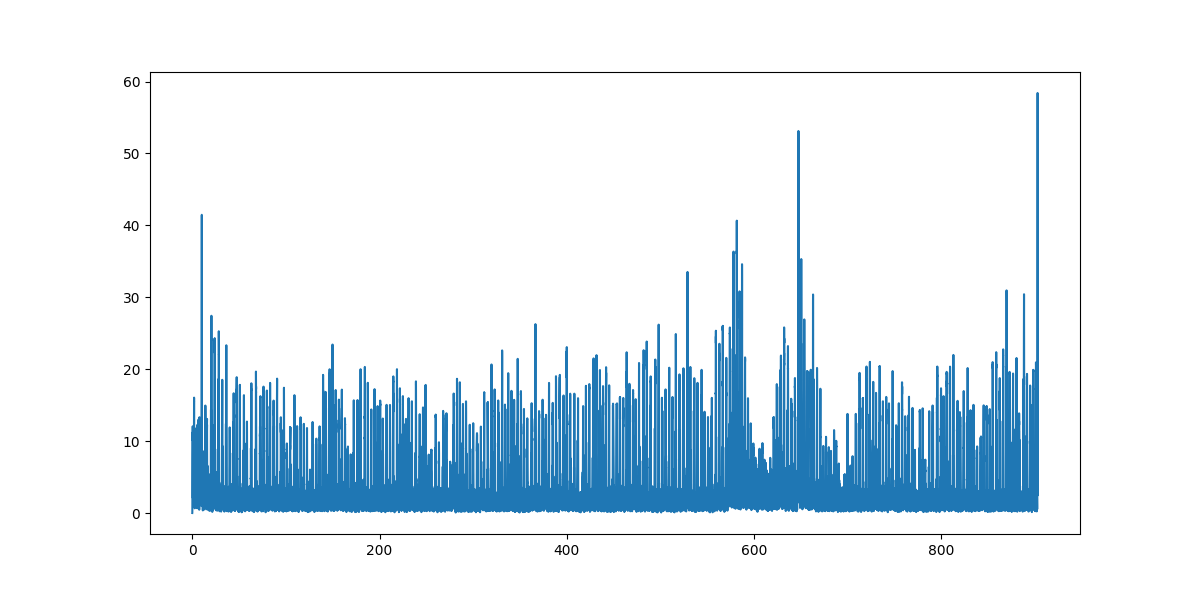

In [13]:
# Calculate the envelope of the signal
emg_timeseries.envelope()
# Which equals:
# emg_timeseries.envelope(
#     env_window=None,
#     env_type='rms',
#     signal_type='clean',
# )
# Where:
# env_window:           Envelope window width, `None` defaults to fs // 5
# env_type:             'rms' for root-mean-square (default), 'arv' for average
#                       rectified
# signal_type:          Calculate the envelope over the clean data

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_env
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(t_emg,emg_timeseries.channels[0].y_env)

In [14]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.baseline()
# Which equals:
# emg_timeseries.baseline(
#     percentile=33,
#     window_s=int(7.5 * fs_emg),
#     step_s=fs_emg // 5,
#     method='default',
#     signal_type='env',
#     augm_percentile=25,
#     ma_window=None,
#     perc_window=None,
#     channel_idxs=[0, 1], 
# )
# Where:
# percentile:       Percentile of signal in the window to take as the baseline
#                   value 
# window_s:         Window length in samples (default: int(7.5 * fs))
# step_s:           Number of consecutive samples with the same baseline value
#                   (default: fs // 5)
# method:           'default' or 'slopesum'
# signal_type:      Calculate the baseline over the envelope (y_env) for emg 
#                   and over the original signal for p_vent
# augm_percentile   Augmented_percentile for slopesum baseline
# ma_window:        Moving average window in samples for average dy/dt in
#                   slopesum baseline
# perc_window:      'perc_window' for slopesum baseline.
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_baseline

vent_timeseries.baseline(
    channel_idxs=[0],
    signal_type='raw')


c:\Users\cmelb\anaconda3\envs\SEISMIC_study\lib\site-packages\resurfemg\data_classes\data_classes.py:1434: UserWarning: More axes provided than channels to plot.
  warnings.warn('More axes provided than channels to plot.')


(370.0, 375.0)

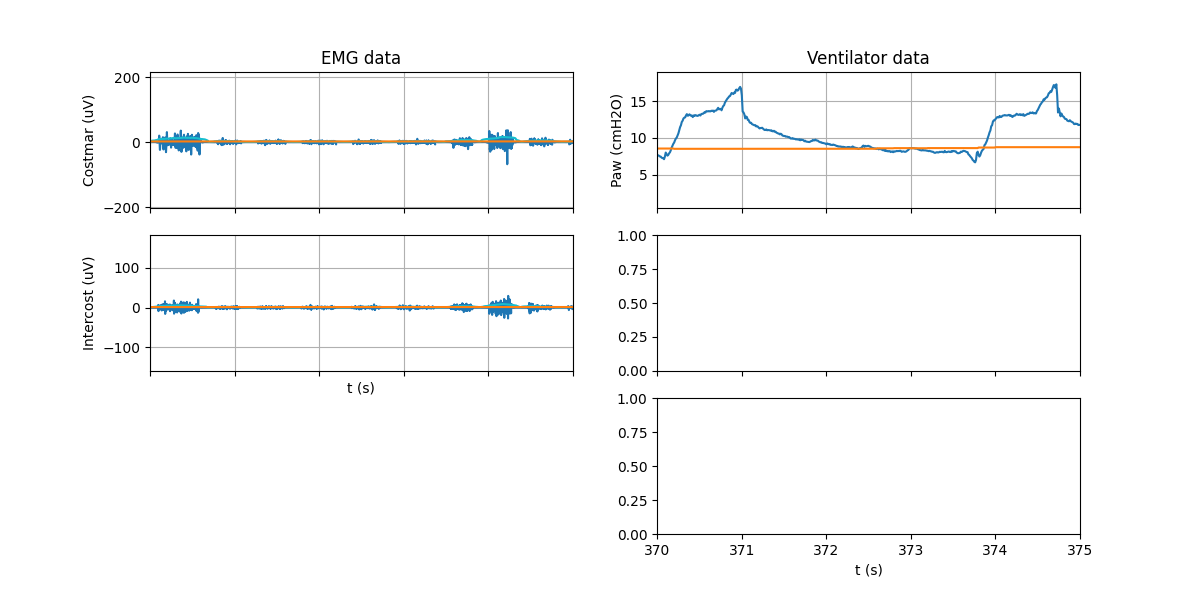

In [15]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg = axis[:2, 0]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.plot_full(
    axes=axes_emg, signal_type='clean', baseline_bool=False)
# Which equals:
# emg_timeseries.plot_full(
#     axes=axes_emg,
#     channel_idxs=[0, 1],
#     signal_type='clean',
#     colors=['tab:cyan', 'tab:orange'],
#     baseline_bool=False
# )
# Where:
# axes:             Matplotlib axes object
# channel_idxs:     For all channels (None would default to this)
# signal_type:      Plot clean emg
# colors:           Plot the signal, and baseline in the respective colors
# baseline_bool:    Plot the baseline

emg_timeseries.plot_full(axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')
axes_emg[0].set_xlim([370, 400])

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

axis[-1, 0].axis('off')

axes_vent[-1].set_xlim([370, 375])

# 4. Quality assesment of preprocessed signal

In [16]:
emg_timeseries.save_instance('data_opgeslagen.pkl')

In [1]:
import pickle

def load_instance(filename):
    # Load the instance from a file using pickle
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Load the saved instance
emg_timeseries = load_instance('data_opgeslagen.pkl')

In [2]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.quality_check()
# Which equals:
# emg_timeseries.baseline(
#     percentile=33,
#     window_s=int(7.5 * fs_emg),
#     step_s=fs_emg // 5,
#     method='default',
#     signal_type='env',
#     augm_percentile=25,
#     ma_window=None,
#     perc_window=None,
#     channel_idxs=[0, 1], 
# )
# Where:
# percentile:       Percentile of signal in the window to take as the baseline
#                   value 
# window_s:         Window length in samples (default: int(7.5 * fs))
# step_s:           Number of consecutive samples with the same baseline value
#                   (default: fs // 5)
# method:           'default' or 'slopesum'
# signal_type:      Calculate the baseline over the envelope (y_env) for emg 
#                   and over the original signal for p_vent
# augm_percentile   Augmented_percentile for slopesum baseline
# ma_window:        Moving average window in samples for average dy/dt in
#                   slopesum baseline
# perc_window:      'perc_window' for slopesum baseline.
# channel_idxs:     For all channels (None would default to this)

Curve fitting failed for peak index 1607 with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Test values:
      peak_idx        snr        aub      bell
0          985   1.648440  72.474927  4.179707
1         2116   1.532805  73.218888  2.118886
2         2943   1.378367  81.815031  1.523552
3         3960   2.155764  59.169519  2.086158
4         4972   1.399171  78.920984  1.357071
...        ...        ...        ...       ...
1603   1844328   1.210285  84.306613  1.811844
1604   1845579   9.430498  16.479230  9.891646
1605   1846487   1.896309  65.133011  2.433082
1606   1847611   1.241292  90.194042  3.662791
1607   1849064  27.752965   7.425501  0.000000

[1608 rows x 4 columns]
Test outcomes:
      peak_idx  baseline_detection  interpeak_distance    snr    aub  bell
0          985                True               False   True  False  True
1         2116                True               False   True  False  True
2         2943     